# Hedging Uniswap V3 with Options

In [3]:
import plotly.graph_objs as go
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 0.6

#### Here we will show how options can be used to hedge liquidity providers’ Uniswap V3 positions.

Let’s say a liquidity provider opened a position on the **USDC-ETH** pair.

Liquidity providers set the desired price range in which their provided tokens will be used and receive swap fees. The narrower the range, the more fees it will earn on each swap. With a narrow range, the price will exit it faster, and the position will no longer earn commissions.

Let’s consider how the total portfolio value of a position of a liquidity provider depends on the price of ether.

In [4]:
def get_liquidity_from_token0(x0, p0, pb):
    """
        This function returns liquidity from token0 amount
    """
    return x0 / (1 / (p0)**0.5 - 1 / (pb)**0.5)

def get_token1_amount_from_upper_price(L, pa, pb):
    """
        This function returns the amount of token1 when price crosses upper price
    """
    return L * (pb**0.5 - pa**0.5)

def get_token0_amount_from_lower_price(L, pa, pb):
    """
        This function returns the amount of token0 when price drops lower than lower price
    """
    return L * (1 / (pa**0.5) - 1 / (pb**0.5))


def uniswap_v3_total_value(k, L, p0, pa, pb):
    """
        This function returns the total value of uniswap v3 position depending on price and position params
    """
    
    if p0*k >= pa and p0*k <= pb:
        return 2 * L * (p0*k) ** 0.5 - L * ((pa)**0.5 + (p0 * k) / ((pb) ** 0.5))
    
    elif p0*k > pb:
        return get_token1_amount_from_upper_price(L, pa, pb)
        
    elif p0*k < pa:
        return get_token0_amount_from_lower_price(L, pa, pb) * p0 * k

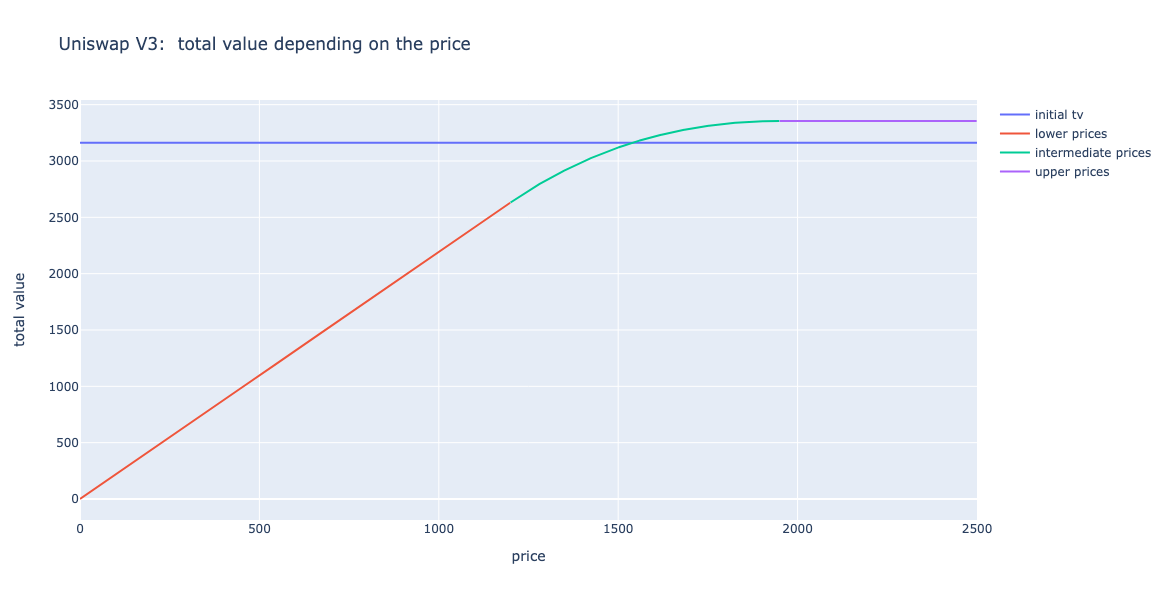

In [5]:
prices = np.array([price for price in range(0, 2501)])
price0 = 1540
pa = 1200
pb = 1950
x0 = 1 # e.g. ethers

liquidity = get_liquidity_from_token0(x0, price0, pb)

lower_prices = np.array([price for price in range(0, pa)])

uniswap_v3_tvs_lower_prices = np.array([uniswap_v3_total_value(k=price / price0, 
                                                  L=liquidity, 
                                                  p0=price0, 
                                                  pa=pa, 
                                                  pb=pb) for price in lower_prices])

intermediate_prices = np.array([price for price in range(pa, pb)])

uniswap_v3_tvs_intermediate_prices = np.array([uniswap_v3_total_value(k=price / price0, 
                                                  L=liquidity, 
                                                  p0=price0, 
                                                  pa=pa, 
                                                  pb=pb) for price in intermediate_prices])

# calculating initial total value
initial_tvs = np.array([uniswap_v3_total_value(k=1, 
                                      L=liquidity, 
                                      p0=price0, 
                                      pa=pa, 
                                      pb=pb) for price in prices])

upper_prices = np.array([price for price in range(pb, max(prices))])

uniswap_v3_tvs_upper_prices = np.array([uniswap_v3_total_value(k=price / price0, 
                                                  L=liquidity, 
                                                  p0=price0, 
                                                  pa=pa, 
                                                  pb=pb) for price in upper_prices])

fig = go.Figure()
fig.add_trace(go.Scatter(x=prices, y=initial_tvs, mode='lines', name='initial tv'))
fig.add_trace(go.Scatter(x=lower_prices, y=uniswap_v3_tvs_lower_prices , name='lower prices'))
fig.add_trace(go.Scatter(x=intermediate_prices, y=uniswap_v3_tvs_intermediate_prices, name='intermediate prices'))
fig.add_trace(go.Scatter(x=upper_prices, y=uniswap_v3_tvs_upper_prices, name='upper prices'))

fig.update_layout(title='Uniswap V3:  total value depending on the price', xaxis_title='price', yaxis_title='total value', width=850, height=600)
fig.show()


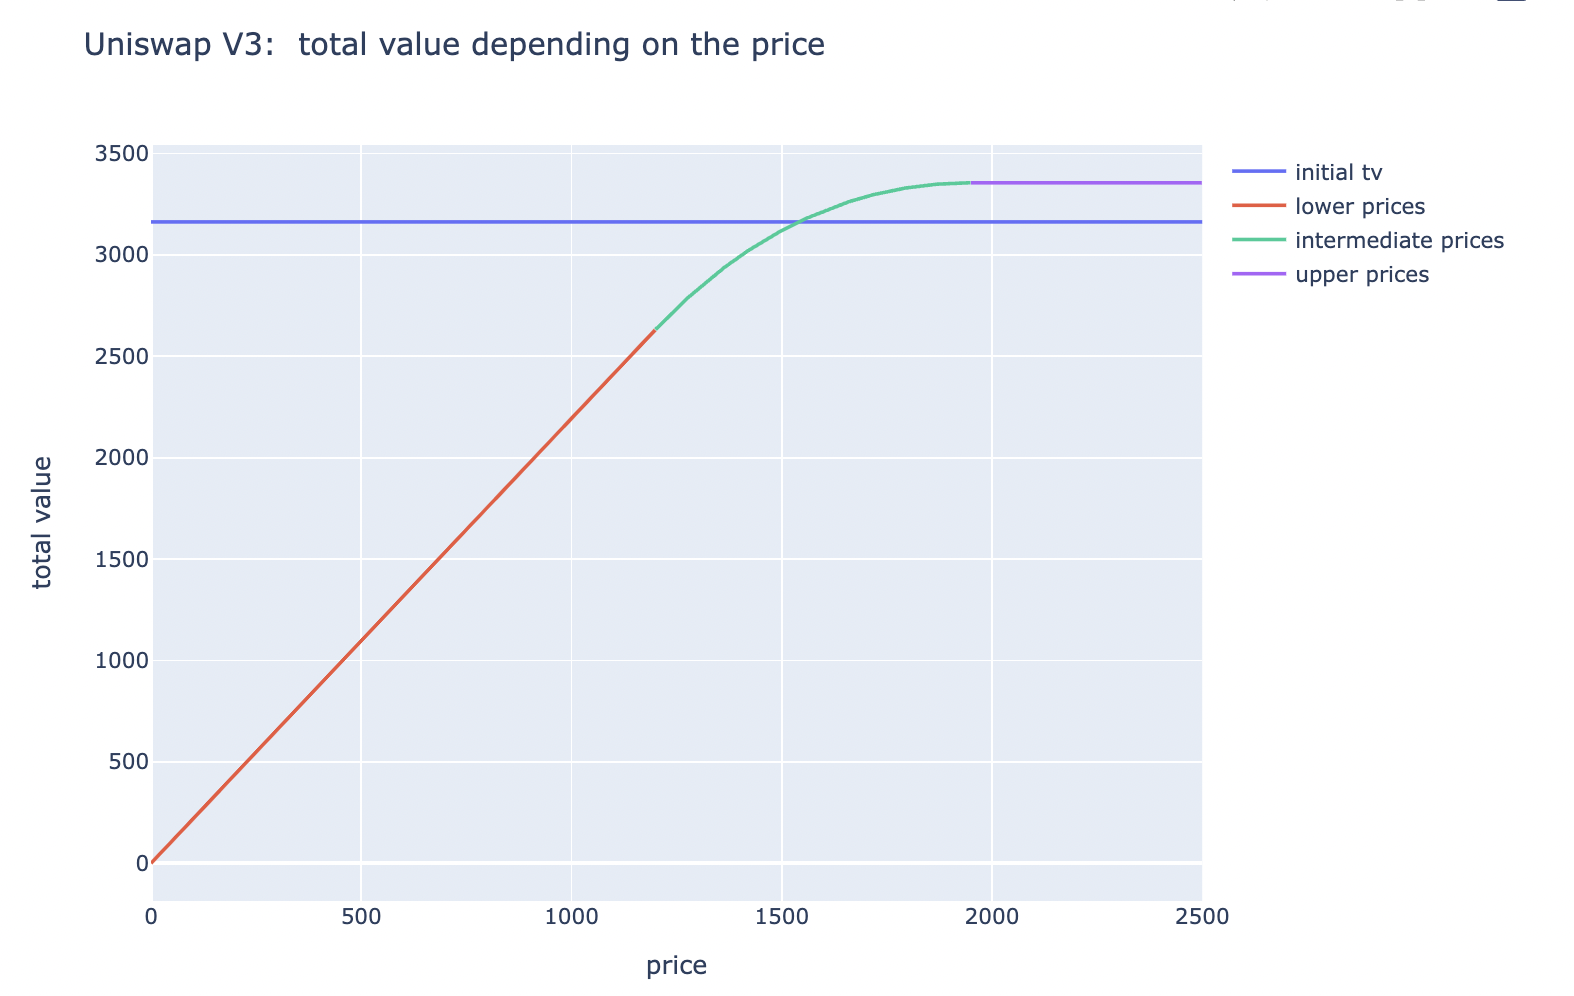

### What is the problem with this position?
The problem is that if the price goes down, then the liquidity provider will take more and more losses. At first, due to the curvature of the Uniswap V3 position (as long as the price is in the range), the loss will not be that big, but as the price moves down, the loss will increase more and more.

##### This means that the liquidity provider has an open risk on the price of the underlying asset.

### What can a liquidity provider do?
The liquidity provider can buy the option, then the position will not be so dependent on the price of the underlying asset.

### Calculating put option payoff


$$Payoff = max(0, K - S_T) - P_0$$

$S_T$ - underlying asset price at the expiry <br/>
$K$ - strike price <br/>
$P_0$ - option price ($t=0$)

#### The payoff depending on the asset price at the expiry will look as follows:


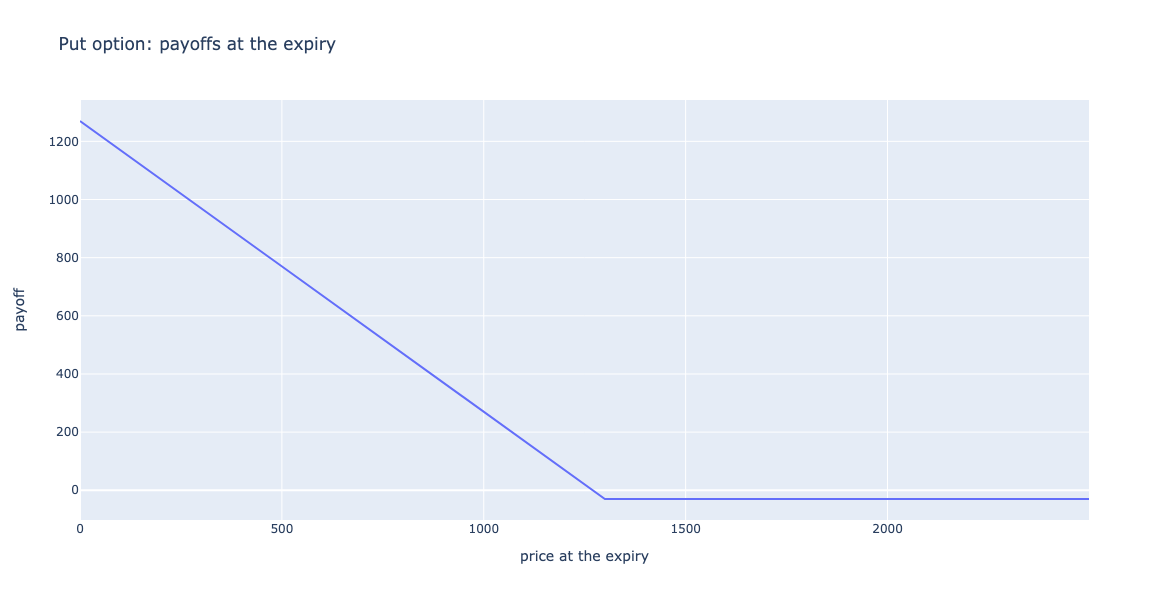

In [6]:
K = 1300 # strike price

P0 = 30

prices = np.array([price for price in range(0, 2500)])
puts = [max(0, K - price) - P0 for price in prices]


fig = go.Figure()
fig.update_layout(title='Put option: payoffs at the expiry', xaxis_title='price at the expiry', yaxis_title='payoff', width=850, height=600)

fig.add_trace(go.Scatter(x=prices, y=puts, mode='lines', name='initial tv'))

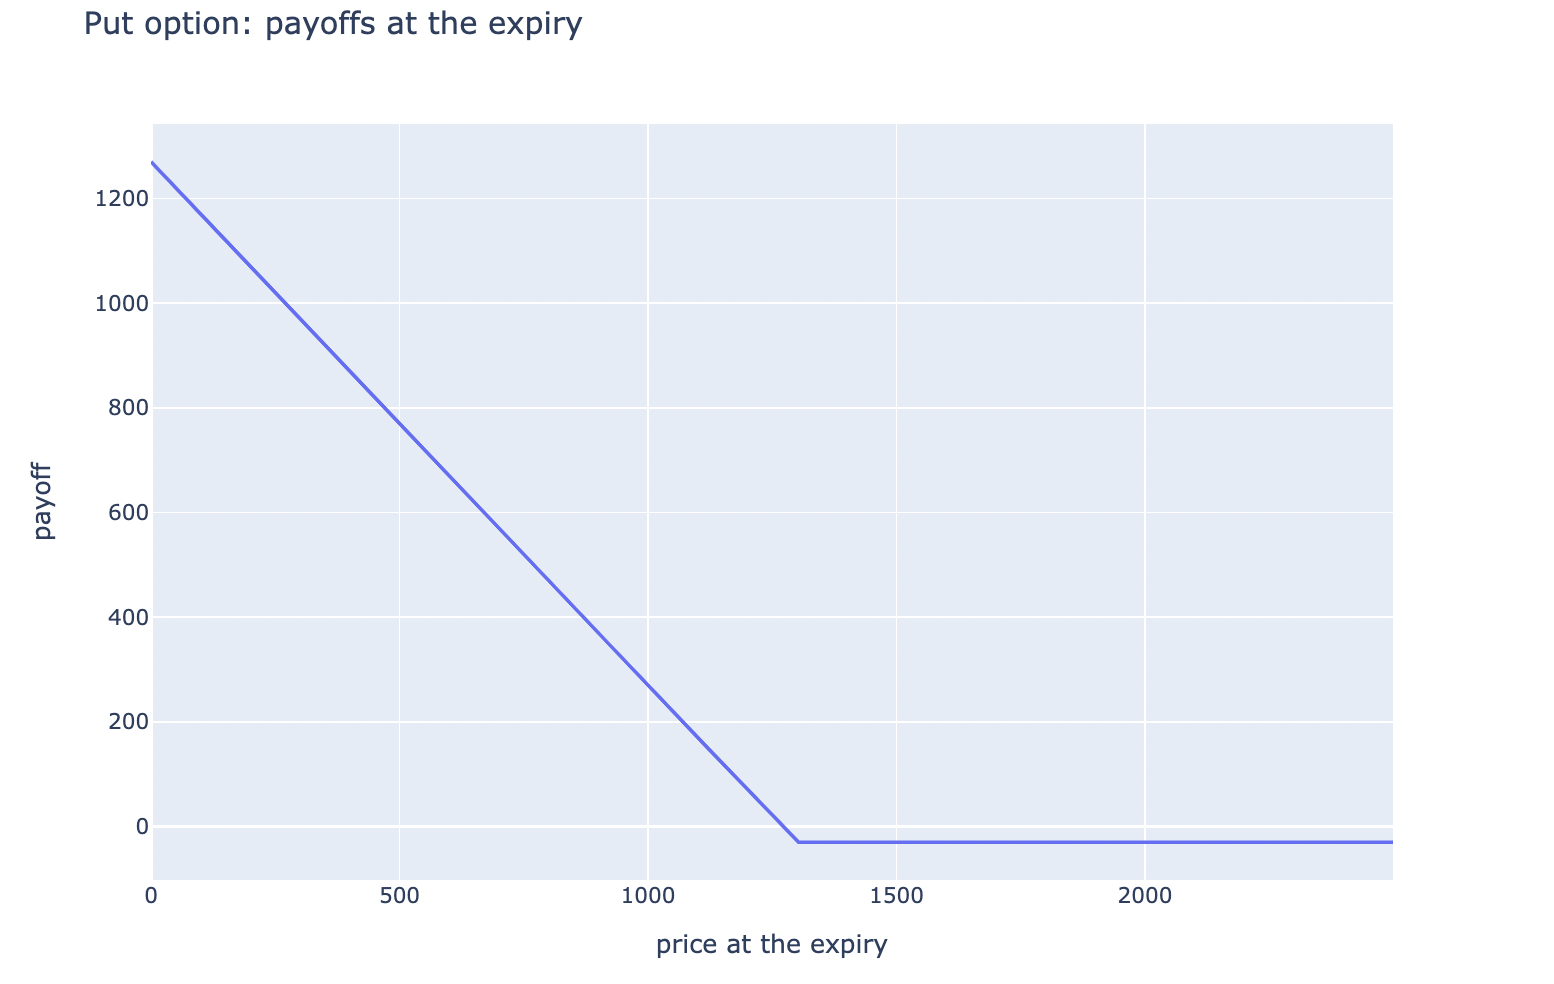

#### Thus, if a liquidity provider opens a Uniswap V3 position and then buys a put option, then its total risk profile will look like this:

In [8]:
univ3_tvs = list(uniswap_v3_tvs_lower_prices) + list(uniswap_v3_tvs_intermediate_prices) + list(uniswap_v3_tvs_upper_prices)

new_univ3_tvs = np.array(univ3_tvs) + 2.2 * np.array(puts)

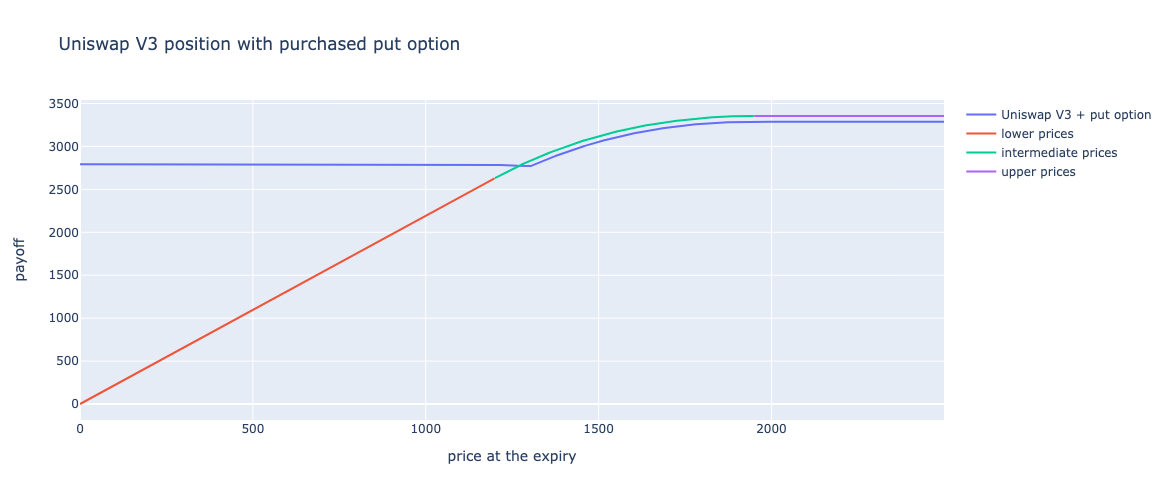

In [9]:
fig = go.Figure()
fig.update_layout(
    autosize=False,
    width=900,
    height=500)
fig.add_trace(go.Scatter(x=prices, y=new_univ3_tvs, mode='lines', name='Uniswap V3 + put option'))
# fig.add_trace(go.Scatter(x=prices, y=initial_tvs, mode='lines', name='initial tv'))
fig.add_trace(go.Scatter(x=lower_prices, y=uniswap_v3_tvs_lower_prices , name='lower prices'))
fig.add_trace(go.Scatter(x=intermediate_prices, y=uniswap_v3_tvs_intermediate_prices, name='intermediate prices'))
fig.add_trace(go.Scatter(x=upper_prices, y=uniswap_v3_tvs_upper_prices, name='upper prices'))

fig.update_layout(title='Uniswap V3 position with purchased put option', xaxis_title='price at the expiry', yaxis_title='payoff')

# fig.add_hline(y=-0.3, line_color="rgba(0,0,0,0)")


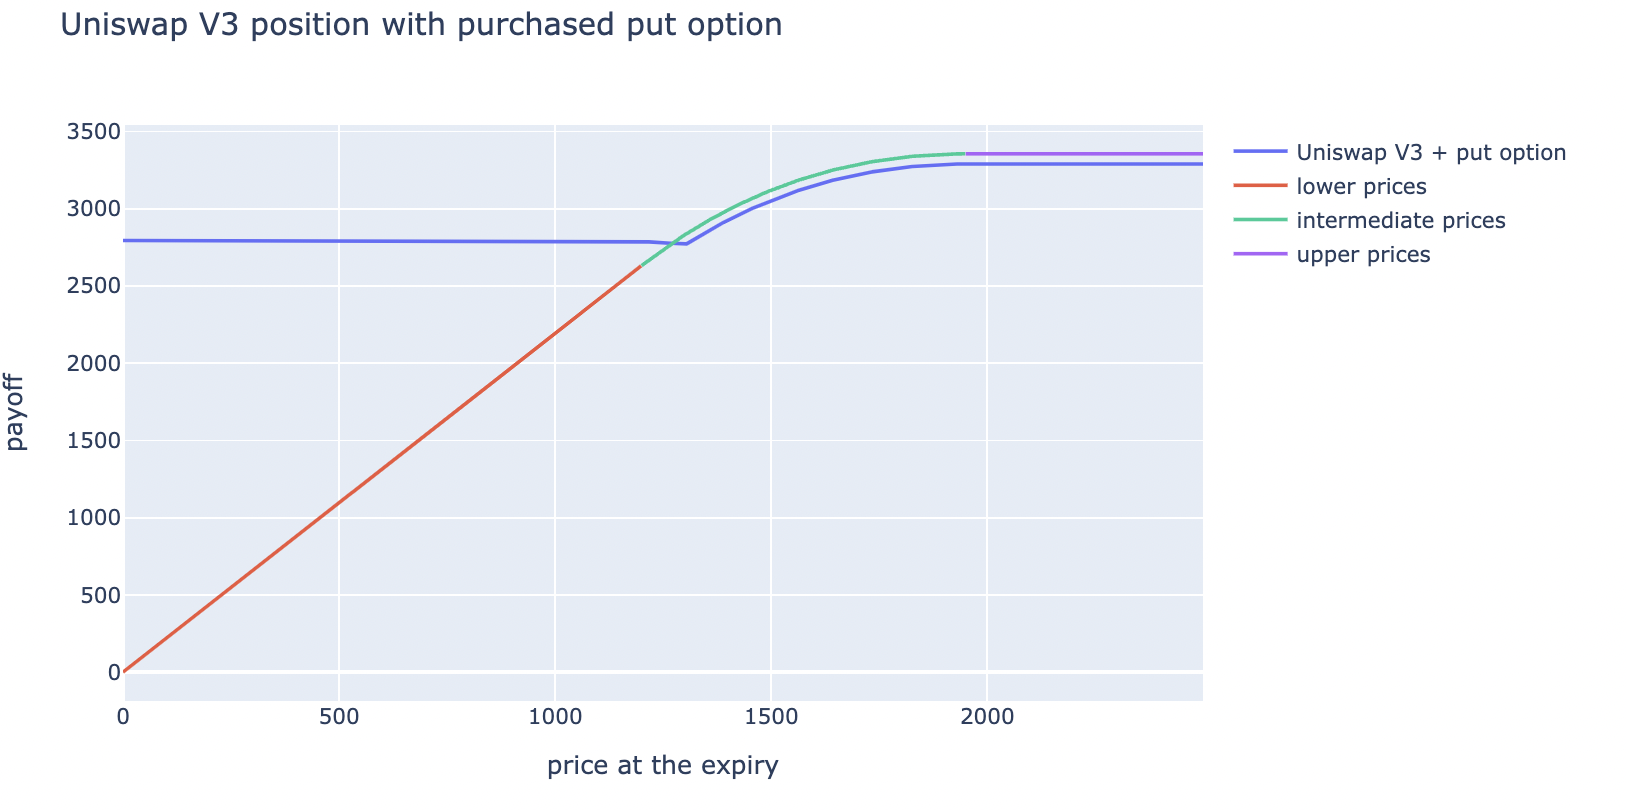

Ultimately, the liquidity provider has a lot less risk while still earning fees by providing liquidity in Uniswap V3.

Therefore, options in the near future will be one of the key tools for risk management in the DeFi space.

